<a id="topL"></a>

# Working with the COS Line Spread Function

# Learning Goals
### This Notebook is designed to walk the user (*you*) through: **Working with the COS Line Spread Function(LSF) to simulate, fit, or model COS observations**
   #### 1. [**Understanding the Line Spread Function**](#undL)
   ##### - 1.1. [What is an LSF?](#whatL)
   ##### - 1.2. [Getting the files you need](#whichL)

   #### 2. [**Taking a look at the LSF kernels**](#lookL)
   ##### - 2.1. [Reading in an LSF](#readL)
   ##### - 2.2. [Plotting an LSF kernel](#plotL)

   #### 3. [**Convolving an LSF**](#convL)
   ##### - 3.1. [Defining some functions for LSF convolution](#funcL)
   ##### - 3.2. [Convolving simple line profiles](#picketL)
   ##### - 3.3. [Convolving real data from STIS](#stisL)



# 0. Introduction
#### The Cosmic Origins Spectrograph ([*COS*](https://www.nasa.gov/content/hubble-space-telescope-cosmic-origins-spectrograph)) is an ultraviolet spectrograph on-board the Hubble Space Telescope([*HST*](https://www.stsci.edu/hst/about)) with capabilities in the near ultraviolet (*NUV*) and far ultraviolet (*FUV*).

#### This tutorial aims to prepare you to work with the COS data of your choice by walking you through convolving a template or high-resolution spectrum with the COS LSF.

- For an in-depth manual to working with COS data and a discussion of caveats and user tips, see the [COS Data Handbook](https://hst-docs.stsci.edu/display/COSDHB/).
- For a detailed overview of the COS instrument, see the [COS Instrument Handbook](https://hst-docs.stsci.edu/display/COSIHB/).


In [3]:
from astropy.table import Table
import numpy as np
from astropy.io import fits
from scipy.interpolate import interp1d

from astropy.convolution import convolve

from matplotlib import pyplot as plt

import urllib # To download COS' LSF files within python

In [96]:
# These will be important directories for the notebook
!mkdir ./output
!mkdir ./output/plots
!mkdir ./data

datadir = './data/'
outputdir = './output/'
plotsdir = './output/plots/'

mkdir: ./output: File exists
mkdir: ./output/plots: File exists
mkdir: ./data: File exists


<a id = undL></a>
# 1. Understanding the Line Spread Function

Each COS observation is taken with a specific **grating** and a specific **central wavelength setting** (**cenwave**). Each such configuration (grating and cenwave) and thus each COS dataset has a set of corresponding Line Spread Functions (LSFs). 

<a id = whatL></a>
## 1.1. What is an LSF?
A Line Spread Function (LSF) is a model of a spectrograph's response to a monochromatic light source: it explains how an infinitely thin spectral line (a [delta function](https://en.wikipedia.org/wiki/Dirac_delta_function)) input into the spectrograph would be output at the focal plane. A spectrum with infinite sprectral resolution convolved with the COS LSF will reproduce the COS spectral line profiles:

$$True\ Input\ Spectrum \ast COS\ LSF = True\ Output\ Spectrum$$

Of course, we don't have access to a "true", infinite resolution input spectrum, nor can we know the infinite resolution LSF. The best we can do is use a model spectrum, or a spectrum from a higher resolution spectrograph (STIS often works well) and convolve it with a kernel of our LSF model. Convolving these yields our model output spectrum:

$$Model\ Input\ Spectrum \ast COS\ LSF\ Model = Model\ Output\ Spectrum$$

***Note*** *that there is a corresponding spread function in the cross-dispersion direction, known as the cross-dispersion spread function (CDSF). These functions are also modelled by the COS team and hosted on their website listed below. Working with the CDSFs is out of the scope of this notebook.*

#### How does COS handle the LSF?

The COS LSFs are generated using an optical model of the spectrograph in the program [Code V](https://www.synopsys.com/optical-solutions/codev.html), and are then validated using real spectral data obtained with the instrument. The LSF kernels are sampled at regular intervals over the wavelength range of each COS configuration. Each of these wavelengths thus corresponds to an LSF kernel. The kernel size (in [COS "pixels"](https://hst-docs.stsci.edu/cosihb/glossary)) of each LSF varies for the near ultraviolet (NUV) and far ultraviolet (FUV) modes, as does the sample rate (how many Angstroms between sampled kernels). These values are shown below:

### Table 1.1:
<h3><center>Line Spread Function (LSF) kernel parameters for the COS instrument</center><\h3>
<br><\br>


||LSF kernels sampled every... |Kernel size... |
|-|-|-|
|**COS/NUV**|100 Å|321 *pixels*|
|**COS/FUV**|5 Å|101 *pixels*|


#### How are the LSF files structured?

In short, the LSF files are structured as a list of LSF profile kernels. It begins with a space-separated list of central sample wavelengths are the input monochromatic lines used by Code V. These are not to be confused with COS central wavelength settings, or cenwaves. To avoid confusing the two concepts, we'll call the central wavelengths of the LSF kernels the **LSF wavelengths**.


<a id = whichL></a>
## 1.2. Getting the files you need

#### Which LSF files will you need?

This depends on your data's parameters, specifically those listed in Table 1.2.

|**Parameter**|**Corresponding Header Keyword**|**Example used in this notebook**|
|-|-|-|
|Wavelength range|*DETECTOR*|FUV|
|COS lifetime position|*LIFE_ADJ*|3|
|Grating|*OPT_ELEM*|G130M|
|Central wavelength setting|*CENWAVE*|1291|

If your data was taken in COS' NUV configuration, there's only one NUV LSF file which contains all the LSF profiles for the entire NUV. Things are a bit more complicated for FUV data, where you will need to choose an LSF file based on the [COS Lifetime position](https://hst-docs.stsci.edu/cosdhb/appendix-a-cos-lifetime-positions/a-1-cos-lifetime-positions), [grating](https://hst-docs.stsci.edu/cosihb/chapter-13-spectroscopic-reference-material/13-3-gratings), and [central wavelength setting](https://hst-docs.stsci.edu/cosihb/chapter-5-spectroscopy-with-cos/5-5-spanning-the-gap-with-multiple-cenwave-settings) used to capture your data.

You'll also need to get the DISPTAB file associated with your data. You can find all of these in your data's primary fits header. You can do this in DS9 or other software, but we'll briefly do this programmatically below:

In [109]:
fuvFile = './data/lcn502010_x1dsum.fits' # Give the program the path to your data

fuvHeader0 = fits.getheader(fuvFile, ext = 0) # Grab the primary header
print(f"For the file {fuvFile}, the relevant parameters are: ")
param_dict = {} # Make a dict to store what you find here

for hdrKeyword in ['DETECTOR', 'OPT_ELEM', 'LIFE_ADJ', 'CENWAVE', 'DISPTAB']: # print out the relevant values
    try: # For DISPTAB
        value = fuvHeader0[hdrKeyword].split('$')[1] # Save the key/value pairs to the dictionary, DISPTAB needs the split
        param_dict[hdrKeyword] = value
    except: # For other params
        value = fuvHeader0[hdrKeyword] # Save the key/value pairs to the dictionary
        param_dict[hdrKeyword] = value
    print(f"{hdrKeyword} = {value}") # Print the key/value pairs

For the file ./data/lcn502010_x1dsum.fits, the relevant parameters are: 
DETECTOR = FUV
OPT_ELEM = G130M
LIFE_ADJ = 3
CENWAVE = 1291
DISPTAB = 2a81746tl_disp.fits


##### Now that you know *which* LSF files you need, we'll go gather them from the COS team's website:

#### Where can you find the LSF files?
The COS team maintains up-to-date LSF files on the [COS Spectral Resolution page](https://www.stsci.edu/hst/instrumentation/cos/performance/spectral-resolution). Opening up this link leads to a page like that shown in Fig. 1.1, where the LSF files are discussed in detail. The bottom part of this page has links to all the relavent files. The links at the top of the page will take you to the relevant section. In Fig. 1.1, we have circled in black the link to the section pertaining to our data: FUV at the Lifetime Position: 3.

### Fig 1.1
<center><img src=./figures/LSFHomepage.png width ="900" title="COS Spectral Resolution Site"> </center>

Clicking on the circled link takes us to the table of hyperlinks to all the files perataining to data taken with the FUV, Lifetime Postition 3 configutation, shown in Fig. 1.2:

### Fig 1.2
<center><img src=./figures/LSFHomepage2.png width ="900" title="COS Spectral Resolution Site - Lifetime Position 3"> </center>

Circled in solid red is the button to download the LSF file we need for our data with CENWAVE = 1291. Circled in dashed black is the corresponding CDSF.

You can click on the solid red circled button to download the LSF file and move it to this current working directory **or** right-click and select "Download Linked File As..." and download directly to this directory.
* *This step may look somewhat different depending on your browser*
* *If you're unsure of the current working directory, un-comment the `!pwd` statement in the next cell, and run the cell.*

In [5]:
# !pwd

These files can also be downloaded programattically from with python, with the function we define below:

In [130]:
def fetch_files(det, grating, lpPos, cenwave, disptab):
    COS_site_rootname = "https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/cos/"\
    "performance/spectral-resolution/_documents/" # Link to where all the files live - split into 2 lines
    if det == "NUV": # Only one file for NUV
        LSF_file_name = "nuv_model_lsf.dat"
    elif det == "FUV": # FUV files follow a naming pattern
        LSF_file_name = f"aa_LSFTable_{grating}_{cenwave}_LP{lpPos}_cn.dat"
        
    LSF_file_webpath = COS_site_rootname + LSF_file_name # Where to find file online
    urllib.request.urlretrieve(LSF_file_webpath, datadir+LSF_file_name) # Where to save file to locally
    print(f"Downloaded LSF file to {datadir + LSF_file_name}")
    # And we'll need to get the DISPTAB file as well
    disptab_path = datadir + disptab
    urllib.request.urlretrieve(f"https://hst-crds.stsci.edu/unchecked_get/references/hst/{disptab}", disptab_path)
    print(f"Downloaded DISPTAB file to {disptab_path}")

    return LSF_file_name, disptab_path

We'll run this function with the parameters we saved earlier to gather the proper LSF file:

In [131]:
# We'll pass that fetch function the parameters we determined earlier
# This phrasing works because of the order in which we added the params to the dict
LSF_file_name, disptab_path = fetch_files(*list(param_dict.values())) 

Downloaded LSF file to ./data/aa_LSFTable_G130M_1291_LP3_cn.dat
Downloaded DISPTAB file to ./data/2a81746tl_disp.fits


<a id = lookL></a>
# 2. Taking a look at the LSF kernels
<a id = readL></a>
## 2.1. Reading in an LSF
#### Below, we create a simple function to read in an LSF file as an astropy table:

In [37]:
def read_lsf(filename):
    # This is the table of all the LSFs: called "lsf"
    # The first column is a list of the wavelengths corresponding to the line profile, so we set our header accordingly
    lsf = Table.read(filename, format='ascii', header_start=0)

    # This is the range of each LSF in pixels (for FUV from -160 to +160, inclusive)
    # middle pixel of the lsf is considered zero ; center is relative zero
    pix = np.arange(len(lsf)) - len(lsf) // 2 # integer division to yield whole pixels

    # the column names returned as integers.
    lsf_wvlns = np.array([int(k) for k in lsf.keys()])

    return lsf, pix, lsf_wvlns

#### Now let's read the LSF file we downloaded and display the first 5 columns:
*Because this is an FUV file, the columns are 321 values long, corresponding to the 321 pixel size of an LSF kernal in the FUV.*

In [132]:
lsf, pix, lsf_wvlns = read_lsf(datadir + LSF_file_name)
lsf[lsf.colnames[:5]]

1134,1139,1144,1149,1154
float64,float64,float64,float64,float64
4.885797114010963e-06,4.787755984607906e-06,4.713489842513227e-06,4.735199692705489e-06,4.7784485923017495e-06
4.916023102906068e-06,4.873309105308387e-06,4.752957668230419e-06,4.749528365900715e-06,4.8460096205578055e-06
4.941950149310319e-06,4.954122351536572e-06,4.829737664959035e-06,4.819638005845053e-06,4.959435869169078e-06
4.975031355401172e-06,5.043803066313383e-06,4.943558000555235e-06,4.944166202963326e-06,5.105983074318574e-06
5.024945714942217e-06,5.132957330887238e-06,5.08655216831887e-06,5.110203690134147e-06,5.257588174065823e-06
5.1062647374008795e-06,5.226843223712312e-06,5.249334040421822e-06,5.292011369183484e-06,5.4004601352656915e-06
5.22334211429479e-06,5.329101494747061e-06,5.421819580311945e-06,5.476126509683101e-06,5.537769117220119e-06
5.363562444717191e-06,5.438680038755283e-06,5.589977083978292e-06,5.661455266614987e-06,5.679786309281309e-06
5.503054802394619e-06,5.554937875874203e-06,5.742187109577016e-06,5.841583683466683e-06,5.828667384063064e-06


<a id = plotL></a>
## 2.2. Plotting an LSF kernel
#### It's easy enough to plot the LSF kernels to take a look.
Here's a very simple plot of the first LSF kernel sampled at 1134 Å:

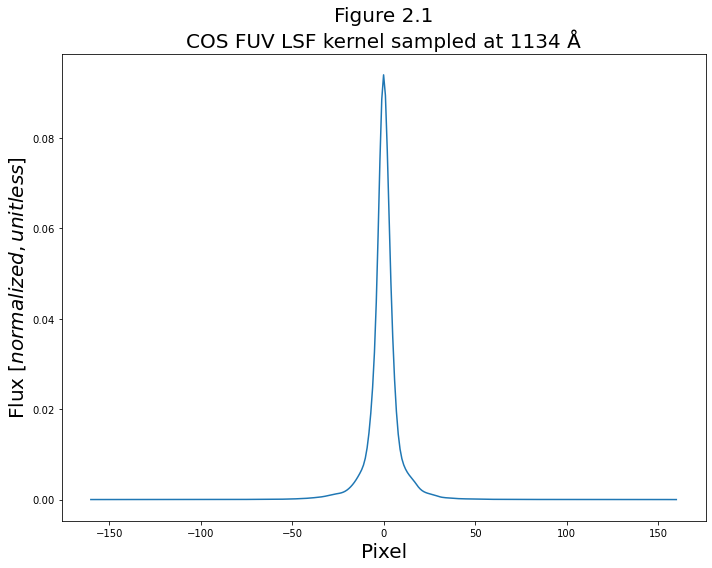

In [82]:
# Set up the figure
plt.figure(figsize = (10,8))
# Fill the figure with a plot of the data
plt.plot(pix, lsf['1134'])
# Give fig the title and labels
plt.title("Figure 2.1\nCOS FUV LSF kernel sampled at 1134 Å", size = 20)
plt.xlabel("Pixel", size = 20)
plt.ylabel("Flux [$normalized,unitless$]", size = 20)
# format and save the figure
plt.tight_layout()
plt.savefig(plotsdir + 'oneKernel.png', bbox_inches = 'tight')

#### We'll now make a more complex plot showing all of the lines contained in the LSF file, distributed in wavelength space
*Note* that while the centers of the lines are correctly mapped to the LSF wavelength at which they were sampled, their kernel width *in pixels* has only been roughly translated to a wavelength range in Å. In short, the x-axis is not strictly to-scale.

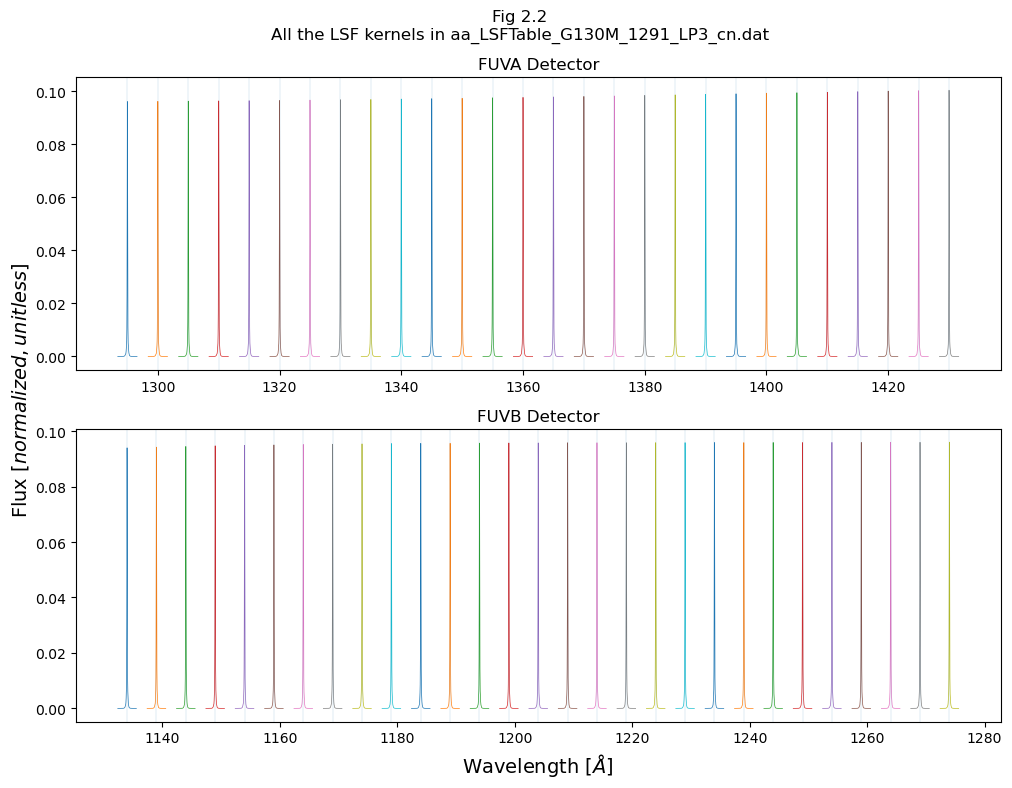

In [81]:
fig, (ax0,ax1) = plt.subplots(2,1, figsize = (10,8), dpi = 100)

# Loop through the lsf kernels
for i, col in enumerate(lsf.colnames):
    line_wvln = int(col) # central position
    contents = lsf[col].data # actual shape
    if line_wvln < 1291: # split into the FUVB segment
        xrange = (0.0099*pix + line_wvln) # ROUGHLY convert pix to wvln
        ax1.plot(xrange , contents, linewidth = 0.5) # Plot the kernel
        ax1.axvline(line_wvln, linewidth = 0.1) # plot the LSF wvln as a faded line
    elif line_wvln > 1291: # split into the FUVA segment
        xrange = (0.0099*pix + line_wvln) # ROUGHLY convert pix to wvln
        ax0.plot(xrange , contents, linewidth = 0.5) # Plot the kernel
        ax0.axvline(line_wvln, linewidth = 0.1) # plot the LSF wvln as a faded line

# Add labels, titles and text
fig.suptitle(f"Fig 2.2\nAll the LSF kernels in {LSF_file_name}")
ax1.set_title("FUVB Detector")
ax0.set_title("FUVA Detector")
ax1.set_xlabel("Wavelength [$\AA$]", size = 14)
fig.text(s = "Flux [$normalized,unitless$]", x = -0.01, y = 0.35, rotation = 'vertical' , size = 14)

# format and save the figure
plt.tight_layout()
plt.savefig(plotsdir + 'allKernels.png', bbox_inches = 'tight')

<a id = convL></a>
# 3. Convolving an LSF

Now we come to the central point of the notebook, convolving a spectrum with the COS LSF. We'll begin by defining some functions we'll use for the convolution.

<a id = funcL></a>
## 3.1. Defining some functions for LSF convolution

We've already defined a function to read in the LSF file, but we'll need the main function to take a spectrum and convolve it with the LSF kernel. We'll call this function:`convolve_lsf`. This function will, in turn, call two short functions: `get_disp_params` to and `redefine_lsf`:

### First, we'll define a function, `get_disp_params`, to interpret the DISPTAB and find the dispersion relationship:

In [133]:
def get_disp_params(disptab, cenwave, segment, x=[]):
    """
    Helper function to redefine_lsf(). Reads through a DISPTAB file and gives relevant\
    dispersion relationship/wavelength solution over input pixels
    Parameters:
    disptab (str): path to your DISPTAB file
    cenwave (str): Cenwave for calculation of dispersion relationship
    segment (str): FUV A or B or BOTH?
    x (list): range in pixels over which to calculate
    Returns:
    disp_coeff (list): Coefficients of the relevant polynomial dispersion relationship
    wavelength (list; if applicable): Wavelengths corresponding to input x pixels 
    """
    with fits.open(disptab) as d:
        wh_disp= np.where((d[1].data['cenwave'] == cenwave) &
                          (d[1].data['segment'] == segment) &
                          (d[1].data['aperture'] == 'PSA'))[0]
        disp_coeff = d[1].data[wh_disp]['COEFF'][0] # for some reason this returns nested list [[arr]]
        d_tv03 = d[1].data[wh_disp]['D_TV03'] # Offset from WCA to PSA in Thermal Vac. 2003 data
        d_orbit = d[1].data[wh_disp]['D'] # Current offset from WCA to PSA

    delta_d = d_tv03 - d_orbit

    if len(x):
        wavelength = np.zeros(len(x))
        for power, coeff in enumerate(disp_coeff):
            # calculating the wavelength from xfull by adding to the same array
            #   but going up in powers each time AKA building up a polynomial solution
            wavelength = wavelength + coeff*(x+delta_d)**power
        return disp_coeff, wavelength
    else: # If x is empty:
        return disp_coeff

### Now, we'll define a function, `redefine_lsf`, to apply the dispersion relationship to the LSF kernels.
This effectively converts an LSF kernel from a function of pixel to a function of wavelength, making it compatible with a spectrum.

In [ ]:
def redefine_lsf(lsf_file, cenwave, disptab, detector='FUV'):
    if detector == 'FUV':
        # FUV detector!!
        xfull = np.arange(16384)
        # segments = ['FUVA', 'FUVB']
    elif detector == 'NUV':
        raise NotImplementedError()
        xfull = np.arange(1024)

    ## this block wont work for NUV
    # read the here for the segments and pass that in
    if cenwave != 1105:
        disp_coeff_b, wavelength_b = get_disp_params(disptab, cenwave, 'FUVB', x=xfull)
    else:
        # 1105 doesn't have an FUVB so set it to something arbitrary
        wavelength_b = [-99., 0.]

    disp_coeff_a, wavelength_a = get_disp_params(disptab, cenwave, 'FUVA', x=xfull)

    step = disp_coeff_a[1] 

    ## read in the lsf file
    lsf, pix, w = read_lsf(lsf_file)

    # There might be a better way to do this. IDL shift function can be devious
    # interpolate instead if not linearly spaced ; most people do this though (unfortunately)
    deltaw = np.median(w-np.roll(w, 1)) # getting the median difference between the column headers

    lsf_array = [np.array(lsf[key]) for key in lsf.keys()]
    if deltaw > len(pix)*step*2: #this seems super arbitary
        raise ValueError('deltaw too large:\ndeltaw:{}\nthreshold:{}'.format(deltaw, len(pix)*step*2))

    # this is all a set up of the bins we want to use I think
    new_deltaw = round(len(pix)*step*2.)
    new_nw = int(round((max(w)-min(w))/new_deltaw))+1 # nw = number of wavelengths
    new_w = min(w) + np.arange(new_nw)*new_deltaw
    # new_w = np.linspace(min(w), max(w), new_nw) # code review replacement. Test this. Might need to add to max to get the last value

    # populating the lsf with the proper bins
    # changed new_nw to be an int on round line

    # might be a much simpler way to do this
    # new_lsf = lsf[0::new_deltaw] # make sure you know where you're starting

    new_lsf = np.zeros((len(pix), new_nw)) #empty 2-D array to populate
    for i, current_w in enumerate(new_w):
        dist = abs(current_w - w)

        lsf_index = np.argmin(dist)
        temp_key = lsf.keys()[lsf_index]
        new_lsf[:, i] = np.array(lsf[temp_key])

    return new_lsf, new_w, step

<a id = picketL></a>
## 3.2. Convolving simple line profiles

<a id = stisL></a>
## 3.3. Convolving real data from STIS

|c||||
|-|-|-|-|
|||||
|||||

## Congratulations! You finished this notebook!
### There are more COS data walkthrough notebooks on different topics. You can find them [here](https://github.com/spacetelescope/COS-Notebooks).


---
## About this Notebook
**Author:** Nat Kerman <nkerman@stsci.edu>

**Contributors:** Rachel Plesha

**Updated On:** 2021-01-26

> *This tutorial was generated to be in compliance with the [STScI style guides](https://github.com/spacetelescope/style-guides) and would like to cite the [Jupyter guide](https://github.com/spacetelescope/style-guides/blob/master/templates/example_notebook.ipynb) in particular.*

## Citations

If you use `astropy`, `matplotlib`, `astroquery`, or `numpy` for published research, please cite the
authors. Follow these links for more information about citations:

* [Citing `astropy`/`numpy`/`matplotlib`](https://www.scipy.org/citing.html)
* [Citing `astroquery`](https://astroquery.readthedocs.io/en/latest/)

---

[Top of Page](#topD)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 

<br></br>
<br></br>
<br></br>